In [2]:
%matplotlib inline
import seaborn as sns

import findspark
import os
findspark.init()

import pyspark
from pyspark import SparkContext
from pyspark import SparkFiles
from pyspark import sql
from pyspark import SparkConf
from pyspark import StorageLevel

from pyspark.sql import SQLContext, HiveContext

from pyspark.sql import Row
from pyspark.sql import DataFrameWriter
from pyspark.sql import DataFrameReader
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import GroupedData
from pyspark.sql.functions import UserDefinedFunction

from pyspark.ml import Pipeline
from pyspark.ml.classification import *
from pyspark.ml.feature import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation  import *


from functools import partial
import numpy as np

from datasu.auc import *
from datasu.dicts import *
from datasu.files import *
from datasu.pandas import *a
from datasu.persist import *
from datasu.spark import *


import pandas as pd

In [2]:
conf = SparkConf()
conf.set('spark.executor.memory', '8g')
conf.set('spark.driver.memory', '12g')
conf.set('spark.python.worker.memory', '2g')
conf.set("spark.driver.maxResultSize", "5g")
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
conf.set('spark.executor.extraJavaOptions', '-XX:+PrintGCDetails -XX:+UseCompressedOops')

conf.setAppName('logr3')
conf.getAll()

[(u'spark.serializer', u'org.apache.spark.serializer.KryoSerializer'),
 (u'spark.app.name', u'logr3'),
 (u'spark.master', u'spark://spark1.ea.lab:7077'),
 (u'spark.driver.memory', u'12g'),
 (u'spark.python.worker.memory', u'2g'),
 (u'spark.submit.pyFiles',
  u'/home/ds/.ivy2/jars/com.databricks_spark-csv_2.10-1.3.0.jar,/home/ds/.ivy2/jars/org.apache.commons_commons-csv-1.1.jar,/home/ds/.ivy2/jars/com.univocity_univocity-parsers-1.5.1.jar'),
 (u'spark.executor.extraJavaOptions',
  u'-XX:+PrintGCDetails -XX:+UseCompressedOops'),
 (u'spark.jars',
  u'file:/home/ds/.ivy2/jars/com.databricks_spark-csv_2.10-1.3.0.jar,file:/home/ds/.ivy2/jars/org.apache.commons_commons-csv-1.1.jar,file:/home/ds/.ivy2/jars/com.univocity_univocity-parsers-1.5.1.jar'),
 (u'spark.executor.memory', u'8g'),
 (u'spark.submit.deployMode', u'client'),
 (u'spark.driver.maxResultSize', u'5g'),
 (u'spark.files',
  u'file:/home/ds/.ivy2/jars/com.databricks_spark-csv_2.10-1.3.0.jar,file:/home/ds/.ivy2/jars/org.apache.commo

In [207]:
try:
    sc.stop()
except:
    print 'spark context not exists'

In [ ]:
a=2

In [4]:
sc = pyspark.SparkContext(conf=conf)
sqc = pyspark.SQLContext(sc)
sqlContext = sqc

In [5]:
csv_reader = sqc.read.format('com.databricks.spark.csv').options(header='true', inferschema='true')

## LOAD DATA


In [6]:
base_data_path = '/home/ds/dev/data/Kagle-ValuesShoppers/'

### load spark

In [60]:
spark_data_path = 'file://'+ base_data_path + 'spark_data/'
transactions_name = 'transactions'

In [8]:
ddf_trans_agg_history = csv_reader.load(spark_data_path+'ddf_trans_agg_history', samplingRatio=None)

In [9]:
ddf_trans_agg_history.rdd.getNumPartitions()

400

### load pandas

In [10]:
df_coupons = pd.read_csv(base_data_path+'offers')[['offer','category','company','brand','offervalue','quantity']]
df_offers_ids = pd.read_csv(base_data_path+'trainHistory').rename(columns={'id': 'customer_id'})
df_offers_ids_submission = pd.read_csv(base_data_path+'testHistory').rename(columns={'id': 'customer_id'})

In [11]:
df_offers_all = pd.merge(df_offers_ids, df_coupons, on=['offer'])
df_offers_all = df_offers_all[['customer_id','chain','offer','market','category','company','brand','offerdate','offervalue','quantity','repeattrips','repeater']]

df_offers_all_submission = pd.merge(df_offers_ids_submission, df_coupons, on=['offer'])
df_offers_all_submission = df_offers_all_submission[['customer_id','chain','offer','market','category','company','brand','offerdate','offervalue','quantity']]

In [80]:
main_folder = '/home/ds/dev/data/Kagle-ValuesShoppers/'
load_variables(path=main_folder+'working_data', variables=['df_offers__trans_aggs', 'df_offers_submission__trans_aggs']);

['df_offers_submission__trans_aggs.var', 'df_offers__trans_aggs.var']
loaded df_offers_submission__trans_aggs
loaded df_offers__trans_aggs


In [113]:
ddf_offers__trans_aggs = sqc.createDataFrame(df_offers__trans_aggs).na.fill(0)
ddf_offers_submission__trans_aggs = sqc.createDataFrame(df_offers_submission__trans_aggs).na.fill(0)
# ddf_offers__trans_aggs = ddf_offers__trans_aggs.drop('repeattrips')

## prepare features

In [114]:
categorical_cols = ['chain','market','category','company','brand']
ddf_offers__trans_aggs = convert_columns_to_type(ddf_offers__trans_aggs, categorical_cols, StringType)
ddf_offers_submission__trans_aggs = convert_columns_to_type(ddf_offers_submission__trans_aggs, categorical_cols, StringType)

# build pipes

### build prepare pipe

In [96]:
rf1 = RFormula(formula="repeater ~ . - repeattrips", featuresCol="features", labelCol="label")
pipe_transform1 = Pipeline(stages=[rf1])

std_scale = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=False)
pipe_prepare1 = Pipeline(stages=[std_scale])

## Logr

In [97]:
lr1 = LogisticRegression(featuresCol="features_scaled", labelCol="label", predictionCol="prediction")

# , 
#                          maxIter=100, regParam=0.1, elasticNetParam=0.0, tol=1e-6, fitIntercept=True, 
#                          thresholds=None, probabilityCol="probability",  
#                          rawPredictionCol="rawPrediction", standardization=True, weightCol=None

In [133]:
pipe_lr1 = Pipeline(stages=[pipe_prepare1, lr1])

## Fit models

In [178]:
ddf_offers_submission__trans_aggs = ddf_offers_submission__trans_aggs.withColumn('repeater',F.lit('f'))
ddf_offers_union__trans_aggs = ddf_offers__trans_aggs.unionAll(
                            ddf_offers_submission__trans_aggs.select(*ddf_offers__trans_aggs.columns))

In [179]:
model_transform1 = pipe_transform1.fit(ddf_offers_union__trans_aggs)

In [180]:
ddf_data = model_transform1.transform(ddf_offers__trans_aggs)
ddf_data = ddf_data.select(['features','label']) #, 'repeattrips'])

In [181]:
ddf_data_train, ddf_data_test = ddf_data.randomSplit([0.7, 0.3])

In [182]:
ddf_data_train.groupBy('label').count().collect()

[Row(label=1.0, count=30321), Row(label=0.0, count=81355)]

In [184]:
model_lr1 = pipe_lr1.fit(ddf_data_train) #, params={'weightCol':"repeattrips"})

In [185]:
ddf_data_test_res1 = model_lr1.transform(ddf_data_train, params={'threshold':0.3})

In [186]:
ddf_data_test_res1.columns

['features',
 'label',
 'features_scaled',
 'rawPrediction',
 'probability',
 'prediction']

In [187]:
ddf_data_test_res1.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+----------+
|            features|label|     features_scaled|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+----------+
|(382,[0,2,21,80,1...|  0.0|(382,[0,2,21,80,1...|[1.54735894447094...|[0.82453195398078...|       0.0|
|(382,[0,14,34,51,...|  0.0|(382,[0,14,34,51,...|[1.55332187613428...|[0.82539299622814...|       0.0|
|(382,[0,2,21,57,1...|  0.0|(382,[0,2,21,57,1...|[1.42065738753773...|[0.80544145334885...|       0.0|
|(382,[0,2,21,57,1...|  1.0|(382,[0,2,21,57,1...|[1.36346439713769...|[0.79632217612787...|       0.0|
|(382,[0,6,24,57,1...|  0.0|(382,[0,6,24,57,1...|[0.94812375044413...|[0.72073769258513...|       0.0|
+--------------------+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [188]:
df_data_test_res1 = ddf_data_test_res1.select(['rawPrediction', get_index_from_vector()('probability', F.lit(1)).alias('probability'), 'prediction', 'label']).toPandas()

In [189]:
df_data_test_res1.head()

,rawPrediction,probability,prediction,label
0,"[1.54735894447, -1.54735894447]",0.175468,0,0
1,"[1.55332187613, -1.55332187613]",0.174607,0,0
2,"[1.42065738754, -1.42065738754]",0.194559,0,0
3,"[1.36346439714, -1.36346439714]",0.203678,0,1
4,"[0.948123750444, -0.948123750444]",0.279262,0,0


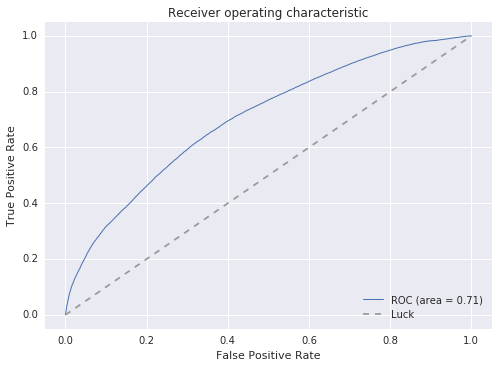

In [190]:
plot_auc(df_data_test_res1.label, df_data_test_res1.probability.values)

### cross-validation

In [ ]:
grid = ParamGridBuilder().build()
evaluator = BinaryClassificationEvaluator()

cv = CrossValidator(estimator=pipe_lr1, estimatorParamMaps=grid, evaluator=evaluator)

cvModel = cv.fit(ddf_data_train)
evaluator.evaluate(cvModel.transform(ddf_data_train))

### submission

In [195]:
ddf_data_submission = model_transform1.transform(ddf_offers_submission__trans_aggs).select(['customer_id','features'])

In [196]:
ddf_data_submission_res1 = model_lr1.transform(ddf_data_submission)

In [197]:
ddf_data_submission_res1.show(10)

+-----------+--------------------+--------------------+--------------------+--------------------+----------+
|customer_id|            features|     features_scaled|       rawPrediction|         probability|prediction|
+-----------+--------------------+--------------------+--------------------+--------------------+----------+
|   66650733|(382,[0,9,28,89,1...|(382,[0,9,28,89,1...|[1.06560275916044...|[0.74375978317848...|       0.0|
|   89804101|(382,[0,3,22,54,1...|(382,[0,3,22,54,1...|[1.29068863349481...|[0.78426372473347...|       0.0|
|   97050374|(382,[0,1,20,86,1...|(382,[0,1,20,86,1...|[0.86963911390964...|[0.70467059956122...|       0.0|
|   97676374|(382,[0,1,20,51,1...|(382,[0,1,20,51,1...|[1.17835414746554...|[0.76465174606442...|       0.0|
|   98407574|(382,[0,1,20,51,1...|(382,[0,1,20,51,1...|[1.17620262523500...|[0.76426433885822...|       0.0|
|   98617174|(382,[0,1,20,99,1...|(382,[0,1,20,99,1...|[1.02273938128083...|[0.73550585415327...|       0.0|
|   99464501|(382,[

In [204]:
df_data_submission_res1 = ddf_data_submission_res1.select(
                [F.col('customer_id').alias('id'), get_index_from_vector()('probability', F.lit(1)).alias('repeatProbability')]).toPandas()

In [205]:
df_data_submission_res1.head()

,id,repeatProbability
0,66650733,0.256240
1,89804101,0.215736
2,97050374,0.295329
3,97676374,0.235348
4,98407574,0.235736


In [206]:
df_data_submission_res1.to_csv(path_or_buf=main_folder+'submission/'+'submission_spark13_LR1', index=False)

## Other

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()
output = ParamGridBuilder() \
         .baseOn({lr.labelCol: 'l'}) \
         .baseOn([lr.predictionCol, 'p']) \
         .addGrid(lr.regParam, [1.0, 2.0]) \
         .addGrid(lr.maxIter, [1, 5]) \
         .build()
            
expected = [
         {lr.regParam: 1.0, lr.maxIter: 1, lr.labelCol: 'l', lr.predictionCol: 'p'},
         {lr.regParam: 2.0, lr.maxIter: 1, lr.labelCol: 'l', lr.predictionCol: 'p'},
         {lr.regParam: 1.0, lr.maxIter: 5, lr.labelCol: 'l', lr.predictionCol: 'p'},
         {lr.regParam: 2.0, lr.maxIter: 5, lr.labelCol: 'l', lr.predictionCol: 'p'}]

len(output) == len(expected)
all([m in expected for m in output])

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.linalg import Vectors
dataset = sqlContext.createDataFrame(
     [(Vectors.dense([0.0]), 0.0),
      (Vectors.dense([0.4]), 1.0),
      (Vectors.dense([0.5]), 0.0),
      (Vectors.dense([0.6]), 1.0),
      (Vectors.dense([1.0]), 1.0)] * 10,
     ["features", "label"])
lr = LogisticRegression()

grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()
evaluator = BinaryClassificationEvaluator()

cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator)
cvModel = cv.fit(dataset)
evaluator.evaluate(cvModel.transform(dataset))

### play with RFormula

In [ ]:
df = sqc.createDataFrame([
     (1.0, 1.0, "a","q"),
     (0.0, 2.0, "b","w"),
     (0.0, 3.0, "a","q"),    
 ], ["y", "x", "cat1","cat2"])
df.show()

In [ ]:
rf = RFormula(formula="y ~ cat1", featuresCol="features", labelCol="label")
df1 = rf.fit(df).transform(df)
df1.show()

rf = RFormula(formula="y ~ cat1+cat2", featuresCol="features", labelCol="label")
df2 = rf.fit(df).transform(df)
df2.show()

rf = RFormula(formula="y ~ cat1:cat2", featuresCol="features", labelCol="label")
df3 = rf.fit(df).transform(df)
df3.show()

rf = RFormula(formula="y ~ cat1:x + cat2:x", featuresCol="features", labelCol="label")
df4 = rf.fit(df).transform(df)
df4.show()

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

scalerModel = scaler.fit(df1)
scalerModel.transform(df1).show()

In [ ]:
from pyspark.sql import Row
from pyspark.mllib.linalg import Vectors

df = sc.parallelize([
     Row(label=1.0, weight=2.0, features=Vectors.dense(1.0)),
     Row(label=0.0, weight=2.0, features=Vectors.sparse(1, [], []))]).toDF()
df.show()

In [ ]:
test0 = sc.parallelize([Row(features=Vectors.dense(-1.0))]).toDF()
result = model.transform(test0).head()
result.prediction

result.probability

result.rawPrediction

test1 = sc.parallelize([Row(features=Vectors.sparse(1, [0], [1.0]))]).toDF()
model.transform(test1).head().prediction

lr.setParams("vector")